In [35]:
import pandas as panda
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [5]:
# !pip install textstat

In [36]:
dataset = panda.read_csv("HateSpeechData.csv")
# dataset

# Adding text-length as a field in the dataset
dataset['text length'] = dataset['tweet'].apply(len)
import seaborn as sns
import matplotlib.pyplot as plt

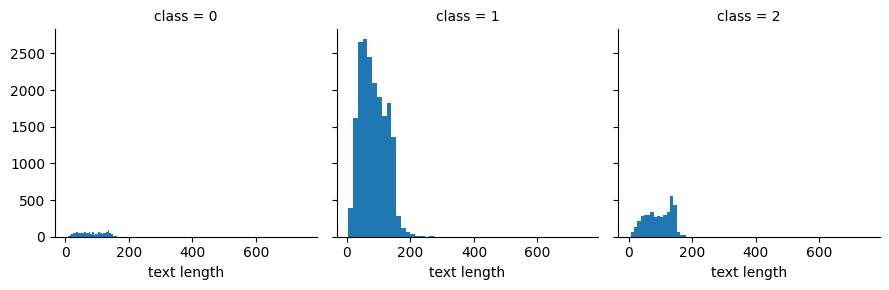

In [37]:
#Basic visualization of data using histograms
# FacetGrid- Multi-plot grid for plotting conditional relationships
import seaborn as sns
import matplotlib.pyplot as plt
graph = sns.FacetGrid(data=dataset, col='class')
graph.map(plt.hist, 'text length', bins=50)

In [38]:
# collecting only the tweets from the csv file into a variable name tweet
tweet=dataset.tweet
import re

In [39]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
## 1. Removal of punctuation and capitlization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming

stopwords = nltk.corpus.stopwords.words("english")

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

def preprocess(tweet):

    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ', regex=True)

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '',regex=True)

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '',regex=True)

    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    tweet_lower = newtweet.str.lower()

    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())

    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])

    # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet

    return tweets_p

processed_tweets = preprocess(tweet)

dataset['processed_tweets'] = processed_tweets


In [41]:
!pip install wordcloud
!pip install wordcloud


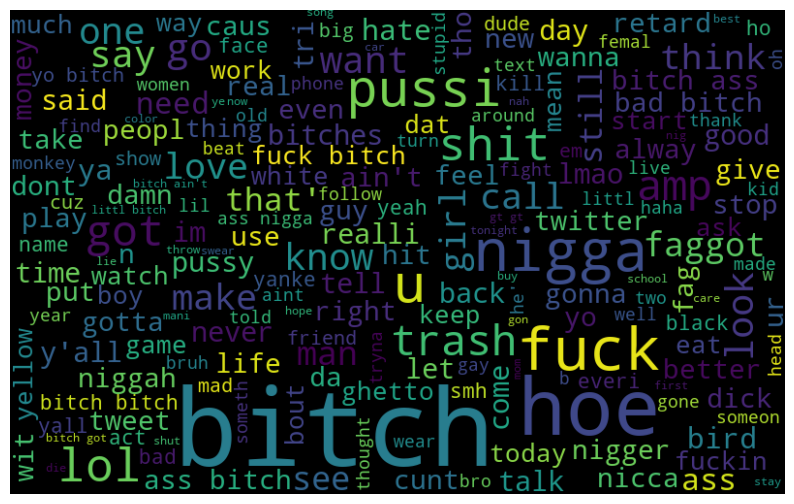

In [42]:
# visualizing which of the word is most commonly used in the twitter dataset
from wordcloud import WordCloud
# imshow-Display data as an image
# interpolation - https://matplotlib.org/3.2.1/gallery/images_contours_and_fields/interpolation_methods.html
all_words = ' '.join([text for text in dataset['processed_tweets'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
#random=0.30
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

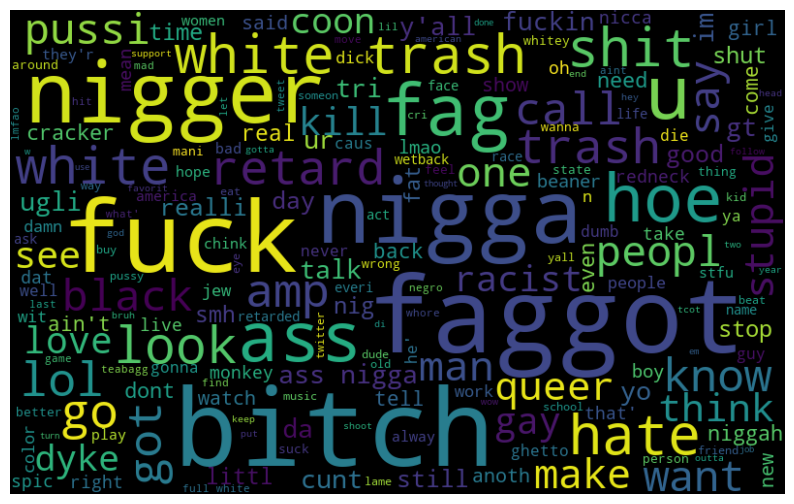

In [43]:
# visualizing which of the word is most commonly used for hatred speech
hatred_words = ' '.join([text for text in dataset['processed_tweets'][dataset['class'] == 0]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(hatred_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [44]:
#TF-IDF Features-F1
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(dataset['processed_tweets'] )
tfidf

<24783x7218 sparse matrix of type '<class 'numpy.float64'>'
	with 211201 stored elements in Compressed Sparse Row format>

In [45]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [46]:
sentiment_analyzer = VS()
def count_tags(tweet_c):

    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', tweet_c)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def sentiment_analysis(tweet):
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    twitter_objs = count_tags(tweet)
    features = [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],twitter_objs[0], twitter_objs[1],
                twitter_objs[2]]
    #features = pandas.DataFrame(features)
    return features

def sentiment_analysis_array(tweets):
    features=[]
    for t in tweets:
        features.append(sentiment_analysis(t))
    return np.array(features)

final_features = sentiment_analysis_array(tweet)
#final_features

new_features = panda.DataFrame({'Neg':final_features[:,0],'Pos':final_features[:,1],'Neu':final_features[:,2],'Compound':final_features[:,3],
                            'url_tag':final_features[:,4],'mention_tag':final_features[:,5],'hash_tag':final_features[:,6]})
new_features


,Neg,Pos,Neu,Compound,url_tag,mention_tag,hash_tag
0,0.000,0.120,0.880,0.4563,0.0,1.0,0.0
1,0.237,0.000,0.763,-0.6876,0.0,1.0,0.0
2,0.538,0.000,0.462,-0.9550,0.0,2.0,0.0
3,0.000,0.344,0.656,0.5673,0.0,2.0,0.0
4,0.249,0.081,0.669,-0.7762,0.0,1.0,1.0
...,...,...,...,...,...,...,...
24778,0.000,0.000,1.000,0.0000,0.0,3.0,3.0
24779,0.454,0.000,0.546,-0.8074,0.0,0.0,0.0
24780,0.000,0.219,0.781,0.4738,0.0,0.0,0.0
24781,0.573,0.000,0.427,-0.7717,0.0,0.0,0.0


In [47]:

# F2-Conctaenation of tf-idf scores and sentiment scores
tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
modelling_features.shape

(24783, 7225)

In [48]:
# create doc2vec vector columns
# Initialize and train the model
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#The input for a Doc2Vec model should be a list of TaggedDocument(['list','of','word'], [TAG_001]).
#A good practice is using the indexes of sentences as the tags.
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(dataset["processed_tweets"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
# window- The maximum distance between the current and predicted word within a sentence.
# mincount-Ignores all words with total frequency lower than this.
# workers -Use these many worker threads to train the model
#  Training Model - distributed bag of words (PV-DBOW) is employed.
model = Doc2Vec(documents,vector_size=5, window=2, min_count=1, workers=4)

#infer_vector - Infer a vector for given post-bulk training document.
# Syntax- infer_vector(doc_words, alpha=None, min_alpha=None, epochs=None, steps=None)
# doc_words-A document for which the vector representation will be inferred.

# transform each document into a vector data
doc2vec_df = dataset["processed_tweets"].apply(lambda x: model.infer_vector(x.split(" "))).apply(panda.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
doc2vec_df

,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,-0.007535,0.118288,0.051044,-0.060085,-0.064743
1,0.310464,-0.033159,0.092001,-0.199119,-0.074952
2,0.223840,0.057277,0.080162,-0.042666,-0.094102
3,-0.023536,-0.076221,0.025520,-0.175428,-0.006950
4,0.170564,0.026708,0.004282,-0.012322,0.034022
...,...,...,...,...,...
24778,0.564950,-0.086503,0.524545,-0.351567,0.017365
24779,0.198555,0.097622,0.027277,0.019010,-0.096582
24780,0.087615,0.115931,-0.007802,-0.019731,-0.085346
24781,0.054488,0.031546,0.034919,-0.056285,-0.041342


In [49]:
pip install gensim textstat

Note: you may need to restart the kernel to use updated packages.


In [50]:

# conctaenation of tf-idf scores, sentiment scores and doc2vec columns
modelling_features = np.concatenate([tfidf_a,final_features,doc2vec_df],axis=1)
modelling_features.shape

(24783, 7230)

In [51]:
#Using TFIDF with sentiment scores,doc2vec and enhanced features
import textstat
def additional_features(tweet):

    syllables = textstat.syllable_count(tweet)
    num_chars = sum(len(w) for w in tweet)
    num_chars_total = len(tweet)
    num_words = len(tweet.split())
    # avg_syl = total syllables/ total words
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(tweet.split()))

    #  Flesch–Kincaid readability tests are readability tests
    #  designed to indicate how difficult a passage in English is to understand.
    # There are two tests, the Flesch Reading Ease, and the Flesch–Kincaid Grade
    # A text with a comparatively high score on FRE test should have a lower score on the FKRA test.
    # Reference - https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests

    ###Modified FK grade, where avg words per sentence is : just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)

    add_features=[FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_words,
                num_unique_terms]
    return add_features

def get_additonal_feature_array(tweets):
    features=[]
    for t in tweets:
        features.append(additional_features(t))
    return np.array(features)

fFeatures = get_additonal_feature_array(processed_tweets)


In [52]:

tfidf_a = tfidf.toarray()
modelling_features_enhanced = np.concatenate([tfidf_a,final_features,doc2vec_df,fFeatures],axis=1)
modelling_features_enhanced.shape

(24783, 7238)

In [53]:

X = panda.DataFrame(modelling_features_enhanced)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test_helo = train_test_split(X, y, random_state=0, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_features,y_train)
y_preds = support.predict(X_test_features)
acc3=accuracy_score(y_test_helo,y_preds)
report = classification_report( y_test_helo, y_preds )
print(report)
print("SVM, Accuracy Score:" ,acc3 )

              precision    recall  f1-score   support

           0       0.62      0.05      0.09       279
           1       0.91      0.96      0.93      3852
           2       0.79      0.82      0.80       826

    accuracy                           0.89      4957
   macro avg       0.77      0.61      0.61      4957
weighted avg       0.87      0.89      0.86      4957

SVM, Accuracy Score: 0.8864232398628202


c:\python\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [54]:
import pickle
#saving
with open('model_name(any).pkl', 'wb') as file:
    pickle.dump(support, file)

#loading
with open('model_name(any).pkl', 'rb') as file:
    loaded_model = pickle.load(file)

#use the loaded_model
# prediction = loaded_model.predict(['input array'])

In [55]:
import pickle

# Saving the model
try:
    with open('model_name.pkl', 'wb') as file:
        pickle.dump(support, file)
    print("Model saved successfully.")
except Exception as e:
    print(f"Error saving model: {e}")

# Loading the model
try:
    with open('model_name.pkl', 'rb') as file:
        loaded_model = pickle.load(file)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

# Using the loaded model
try:
    prediction = loaded_model.predict(['input array','hello'])
    print("Prediction:", prediction)
except Exception as e:
    print(f"Error making prediction: {e}")

Model saved successfully.
Model loaded successfully.
Error making prediction: Expected 2D array, got 1D array instead:
array=['input array' 'hello'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.


In [56]:
import pickle
import os

# Assume 'support' is your trained model
# For example: support = YourTrainedModel()

# Specify the filename for the .pkl file
model_filename = 'model_name.pkl'

# Saving the model to a .pkl file in the current directory
try:
    with open(model_filename, 'wb') as file:
        pickle.dump(support, file)
    print(f"Model saved successfully as '{model_filename}'.")
except Exception as e:
    print(f"Error saving model: {e}")

# Loading the model from the .pkl file
try:
    with open(model_filename, 'rb') as file:
        loaded_model = pickle.load(file)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

# Using the loaded model
try:
    # Example input for prediction (ensure the input is in the right format for your model)
    example_input = ['input array']  # Replace with actual input data
    prediction = loaded_model.predict(example_input)
    print("Prediction:", prediction)
except Exception as e:
    print(f"Error making prediction: {e}")


Model saved successfully as 'model_name.pkl'.
Model loaded successfully.
Error making prediction: Expected 2D array, got 1D array instead:
array=['input array'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
